In [1]:
!pip install -r requirements.txt

In [2]:
import vg
import numpy as np
from matplotlib import pyplot as plt

In [3]:
z = np.asarray([0,0,1]) # == z-axis since the game is 2D
# simplified: Laws of reflection
def rotate_after_collision(vec,plane):
    in_vec = np.diff(vec).flatten()
    plane_vec = np.diff(plane).flatten()
    perpendicular = np.cross(plane_vec, z)
    deg = vg.signed_angle(in_vec, perpendicular, z, units="deg")
    return vg.rotate(in_vec, z, 2*deg),90-deg

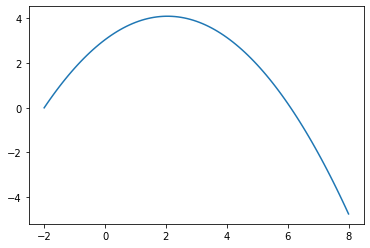

In [4]:
# example of a trajectory
start = np.asarray([-2,0])
velocity = np.asarray([0.1,0.2])
gravity = np.asarray([0.,0.005])

velo = [start]
for _ in range(100):
    velo += [velo[-1]+velocity]
    velocity -= gravity

plt.plot(*np.asarray(velo).T)
plt.show()

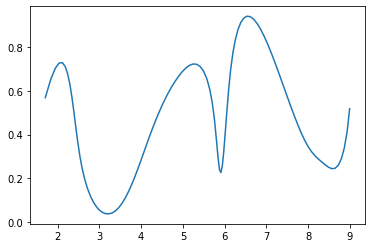

In [5]:
from scipy import interpolate
def get_playground(samples=15):
    x = np.linspace(0,10,samples*10)
    x = np.sort(np.random.choice(x,samples,replace=False))
    y = np.tanh(np.random.random((samples)))
    
    data = np.array((x,y))
    tck,u = interpolate.splprep(data, s=0)
    unew = np.arange(0, 1.01, 0.01)
    return interpolate.splev(unew, tck)

x,y = get_playground(13)
plt.plot(x, y)
plt.show()

In [6]:
x,y = get_playground()

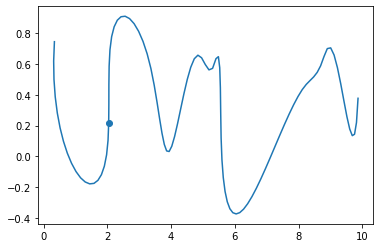

In [7]:
index = np.argwhere(x==np.random.choice(x))
start_x, start_y = np.squeeze(x[index]), np.squeeze(y[index])
plt.plot(x,y)
plt.scatter(start_x,start_y)

In [8]:
start = [start_x, start_y]
velocity = np.asarray([-0.02,0.04])
gravity = np.asarray([0.,0.0007])

y_min, y_max = np.min(y), np.max(y)
x_min, x_max = np.min(x), np.max(x)

def trace_until_collision(start, velocity):
    scalar = 10/(x_max-x_min)
    velo = [start]
    start_x, start_y = velo[-1]
    index = -1
    # TODO: introduce intermediate steps (velocity can grow quickly)
    while True:
        x_current, y_current = velo[-1]
        index = abs(x-x_current).argmin()
        if y_current < y_min: break
        if y_current < y[index]: break
        if x_current < x_min or x_current > x_max: break
            
        velo += [velo[-1]+velocity]
        velocity -= gravity
    # go one step backwards, otherwise the second break condition will break next step again
    velo = velo[:-1]
    
    x_trajectory, y_trajectory = np.asarray(velo).T
    return x_trajectory, y_trajectory, index

def calc_new_velocity(x_trajectory, y_trajectory, index):
    global velocity
    trajectory = np.asarray([x_trajectory[-2:],
                            y_trajectory[-2:],
                            np.zeros(2)])
    plane = np.asarray([[x[index-1],x[index+1]],
                        [y[index-1],y[index+1]],
                        np.zeros(2)])

    last_point = trajectory[:2,1]
    point,degree = rotate_after_collision(trajectory,plane)
    # TODO: new velocity still wrong (the direction has to be corrected)
    velocity = vg.normalize(-1*point)[:2]*np.linalg.norm(velocity)
    attenuation = (1-np.abs(90-degree)/90)
    return last_point, velocity*attenuation

In [9]:
# From: http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
%matplotlib inline
from matplotlib import animation, rc

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

line1, = ax.plot([], [], lw=1)
line2, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1,line2,)

plt.close()

In [10]:
def animate(i):
    global start, velocity
    
    line1.set_data(x,y)
    # TODO: find good point to stop instead of the norm
    # NOTE: keep the numerical instability in mind
    if np.linalg.norm(velocity)<5e-4: return (line1,line2,)
    x_trajectory, y_trajectory, index = trace_until_collision(start, velocity)
    if index <= 1 or index >= x.shape[0]-1: return (line1,line2,)
    if x_trajectory.shape[0] < 2: return (line1,line2,)
    start, velocity = calc_new_velocity(x_trajectory, y_trajectory, index)
    
    line2.set_data(x_trajectory, y_trajectory)
    return (line1,line2,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=30, interval=500, blit=True)

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
anim